# 2022-09-11 • Fit function to STA

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

In [5]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [8]:
s = cached(sim, [p.sim]);

In [9]:
s = augment(s, p);

## STA model ('empirical')

From previous notebook, median input detection rates, for both our old connection test technique (peak-to-peak and area-over-start for exc/inh decision) and the new one, where we cheated with info of the average E→E STA:

```
            ptp-area  corr-with-avgSTA 
──────────────────────────────────────
 exc → exc      0.57              0.79
 exc → inh      0.57              0.82
 inh → exc      0.88              1.00
 inh → inh      0.81              0.96
```

If we don't cheat, but still use the "template"- or "canonical STA shape"-matching idea, can we still beat the `ptp-area` detection rates?

From the "Model PSP" section [here](https://tfiers.github.io/phd/nb/2022-09-05__Why-not-detected.html#model-psp), we have a functional form for a PSP.

..But not for an STA, which shows an additional dimple.  

Let's not research additional theoretical justification for the STA shape (something to do with spike shape and postsynaptic firing probabilities maybe..), but rather make a guess at an empirical function.

For now, we just try to emulate the STA dimple by subtracting a gaussian dip from our exponential model of the PSP.

In [10]:
avgSTA = calc_avg_STA(s, p, postsyn_neurons = 1:40, input_type = :exc);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:139m


In [11]:
using PyPlot
using VoltoMapSim.Plot

In [12]:
centre(x) = x .- mean(x);

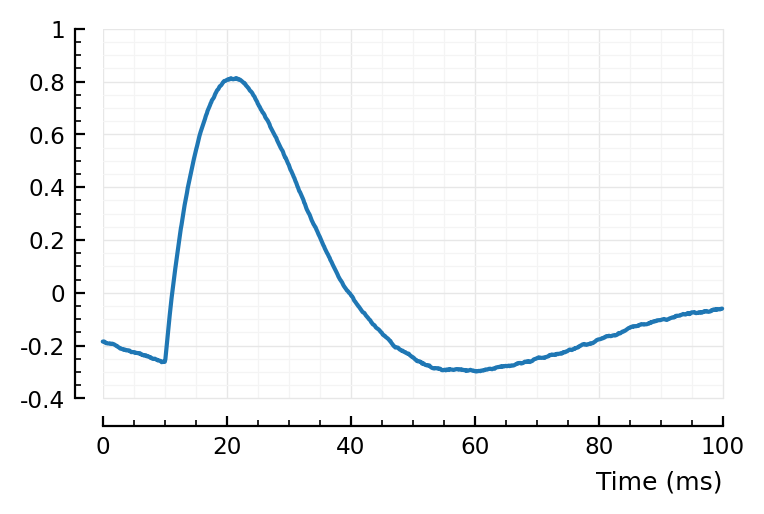

In [13]:
plotsig(centre(avgSTA) / mV, p);

Now to recreate this :)

In [14]:
linear_PSP(t; τ1, τ2) =

    if (τ1 == τ2)   @. t * exp(-t/τ1)
    else            @. τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2))
    end;

# As derived before.
# τ1 = τ_syn
# τ2 = τ_mem
# 
# In the Brian docs, this is called an "alpha" or "biexponential synapse":
# https://brian2.readthedocs.io/en/stable/user/converting_from_integrated_form.html

In [15]:
gaussian(x; loc, scale) = 
    
    @. exp(-( (x-loc)/scale )^2);

# Note that we don't have the factor 1/2 in the exponent (nor the scaling up front).

In [16]:
rescale_to_max!(x) = 
    
    x ./= maximum(abs.(x));

In [17]:
ref_to_start!(x) =
    
    x .-= x[1];

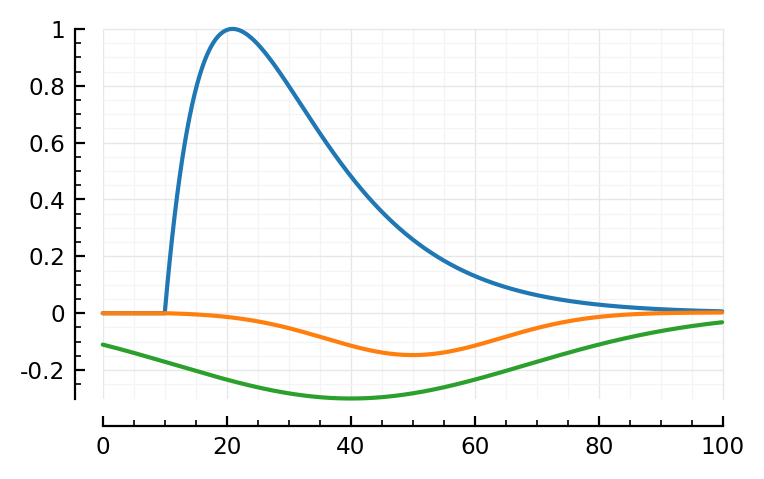

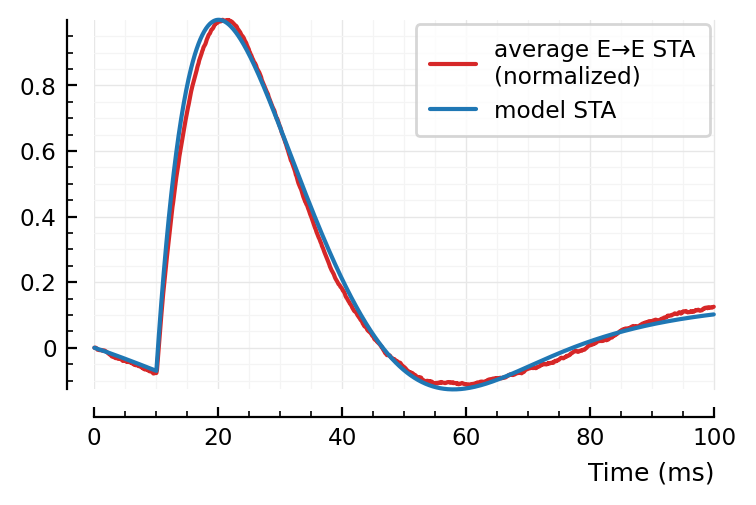

In [18]:
function model_STA(
    p::ExpParams;
    tx_delay = 10ms,
    PSP_bump = (τ1 = 10ms, τ2 = 12ms),
    PSP_dip = (loc = 40ms, scale = 20ms, weight = 0.15),
    STA_dip = (loc = 40ms, scale = 40ms, weight = 0.30),
    plot_components = false,
)
    # Note that `PSP_dip.loc` is relative to `tx_delay`
    
    Δt = p.sim.general.Δt
    STA_duration = p.conntest.STA_window_length
    PSP_duration = STA_duration - tx_delay

    delay_size = round(Int, tx_delay / Δt)
    PSP_size = round(Int, PSP_duration / Δt)
    STA_size = round(Int, STA_duration / Δt)

    t_PSP = collect(linspace(0, PSP_duration, PSP_size))
    t_STA = collect(linspace(0, STA_duration, STA_size))
    
    mult(by) = (x -> x .* by)
    add_delay(x) = vcat(zeros(Float64, delay_size), x)

    τ1, τ2 = PSP_bump
    PSP_bump = (
        linear_PSP(t_PSP; τ1, τ2)
        |> rescale_to_max!
        |> add_delay
    )
    
    loc, scale, weight = PSP_dip
    PSP_dip = (
        gaussian(t_PSP; loc, scale)
        |> rescale_to_max!
        |> mult(-weight)
        |> ref_to_start!   # Zero at t_rel = 0. Avoids artefact at the 'tx_delay' discontinuity.
        |> add_delay
    )
    
    loc, scale, weight = STA_dip
    STA_dip = (
        gaussian(t_STA; loc, scale)
        |> rescale_to_max!
        |> mult(-weight)
    )
    
    STA = (
        (PSP_bump .+ PSP_dip .+ STA_dip)
        |> ref_to_start!
        |> rescale_to_max!
    )

    if plot_components
        plotsig(t_STA / ms, PSP_bump)
        plotsig(t_STA / ms, PSP_dip)
        plotsig(t_STA / ms, STA_dip)
    end
    
    return STA
end

mSTA = model_STA(p, plot_components = true)

normalize!(x) = x |> ref_to_start! |> rescale_to_max!;
normalize(x) = normalize!(copy(x))

plt.subplots()
plotsig(normalize(avgSTA), p, c="C3", label=jn("average E→E STA", "(normalized)"))
plotsig(mSTA, p, label = "model STA")
plt.legend();

Note: first I only added the orange, PSP dip to the blue bump.

Then I noticed two major places where the model didn't fit: the down and upwards ~linear segments at the, respectively, start and end of the average STA.
The green global dip approximates both in one go.

## Fit STA model to average STA

In [19]:
using LsqFit

We have to adapt the model function to conform to LsqFit's API.

In [20]:
p0 = CVec(
    tx_delay = 10ms,
    PSP_bump = (τ1 = 10ms, τ2 = 12ms),
    PSP_dip  = (loc = 40ms, scale = 20ms, weight = 0.15),
    STA_dip  = (loc = 40ms, scale = 40ms, weight = 0.30),
)

p0_vec = collect(p0)
p_buffer = copy(p0)

function toCV(param_vec)
    p_buffer .= param_vec
    return p_buffer
end;

In [21]:
model(t, params) = model_STA(p; toCV(params)...);

In [25]:
# (We don't supply "xdata": our t is fixed).

data = normalize(avgSTA)
@time fit = curve_fit(model, [], data, p0_vec);

  2.704729 seconds (472.81 k allocations: 1.166 GiB, 10.29% gc time)


In [26]:
pfit = toCV(fit.param)

ComponentVector{Float64}(tx_delay = 0.0101, PSP_bump = (τ1 = 0.0139, τ2 = 0.0148), PSP_dip = (loc = 0.0251, scale = 0.0193, weight = 0.29), STA_dip = (loc = 0.05, scale = 0.0326, weight = 0.447))

In [28]:
p0

ComponentVector{Float64}(tx_delay = 0.01, PSP_bump = (τ1 = 0.01, τ2 = 0.012), PSP_dip = (loc = 0.04, scale = 0.02, weight = 0.15), STA_dip = (loc = 0.04, scale = 0.04, weight = 0.3))

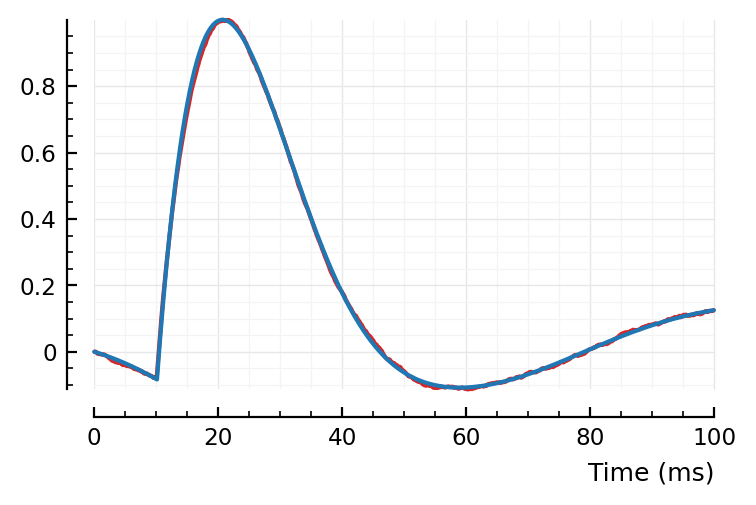

In [31]:
fitted_model = model_STA(p; pfit...)
plotsig(avgSTA |> normalize, p, c="C3")
plotsig(fitted_model, p);

Hah, that's a significantly better fit than my manual one above 😄.

What are the three components now?

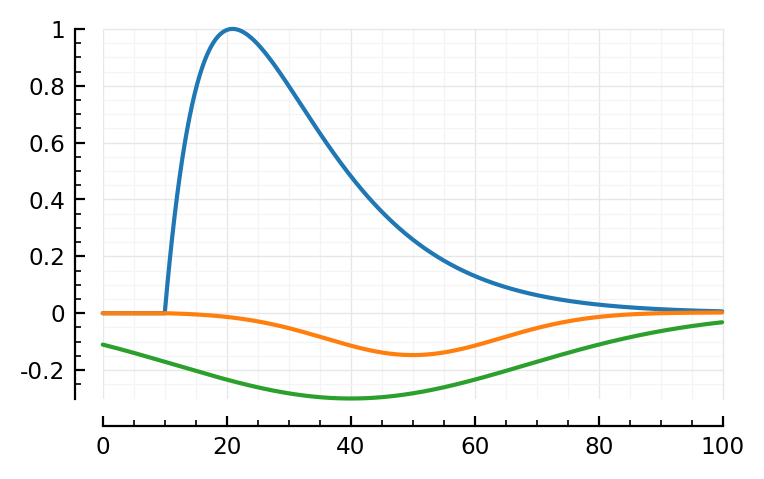

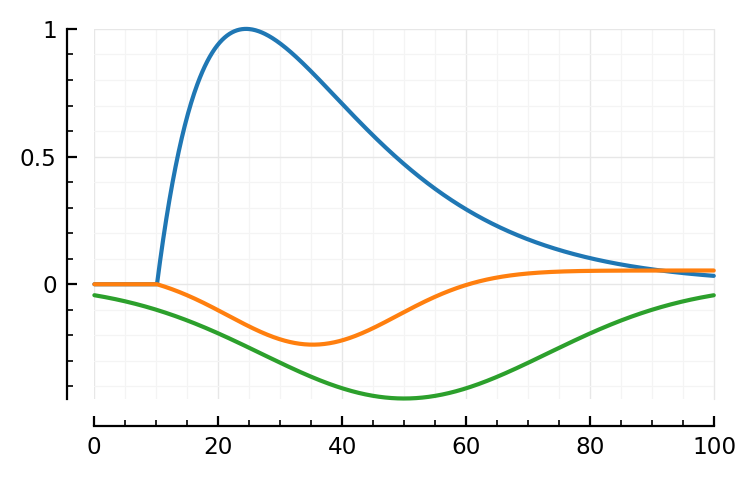

In [32]:
model_STA(p; p0..., plot_components = true); plt.subplots()
model_STA(p; pfit..., plot_components = true);

The linear PSP seems much longer.

In [33]:
pfit.PSP_bump ./ ms

ComponentVector{Float64}(τ1 = 13.9, τ2 = 14.8)

In [34]:
p0.PSP_bump ./ ms

ComponentVector{Float64}(τ1 = 10, τ2 = 12)

Ok so yes a bit longer time constants.

..
And the bumps shifted places.

Note I didn't specify any lower/upper bounds for the parameters. Seems not necessary here (but might be necessary for noisy STAs).

### Profile

need for speed

In [289]:
using ProfileView

In [292]:
@profview curve_fit(model, [], avgSTA, p0_vec);

Most time spent in the actual construction (`PSP_dip = (…))`, and the other two). So that's good.
This is almost all for calculating the Jacobian using finite differences.
So autodiff would help I suspect.

### Can we remove the 'PSP_dip' component?

i.e. just the linear PSP bump, and the global dip.

In [35]:
# p0_vec needs three less params.
# and we'll manually set those to near 0 (not 0, otherwise NaN in scale_max).

In [36]:
no_PSP_dip = (loc = 40ms, scale = 20ms, weight = 1E-6)

p0_2 = CVec(
    tx_delay = 10ms,
    PSP_bump = (τ1 = 10ms, τ2 = 12ms),
    STA_dip  = (loc = 40ms, scale = 40ms, weight = 0.30),
)

p0_2_vec = collect(p0_2)
p2_buffer = copy(p0_2)

function toCV(param_vec, cv_buffer)
    cv_buffer .= param_vec
    return cv_buffer
end;

In [39]:
model2(_, params) = model_STA(p; toCV(params, p2_buffer)..., PSP_dip = no_PSP_dip)

@time fit2 = curve_fit(model2, [], data, p0_2_vec);

  1.270361 seconds (426.71 k allocations: 360.771 MiB, 8.31% gc time, 31.62% compilation time)


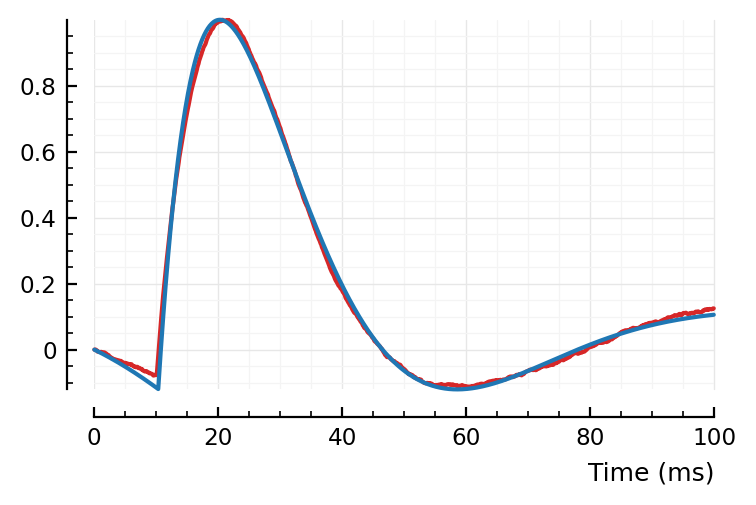

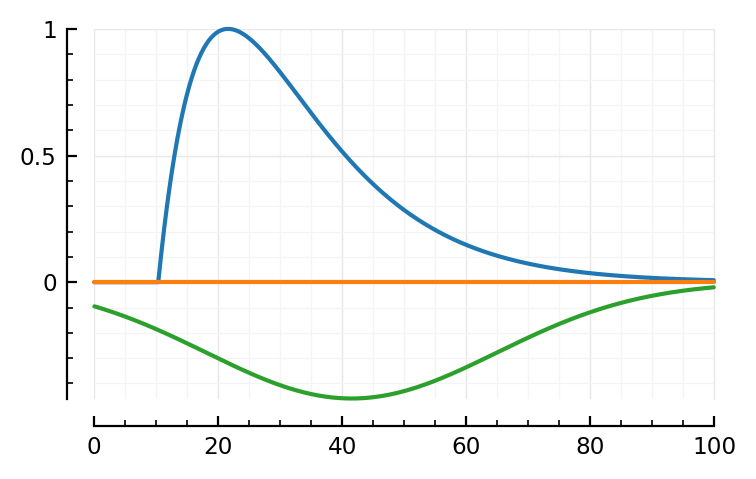

In [41]:
fitted_model2 = model2([], fit2.param)
plotsig(avgSTA |> normalize, p, c="C3")
plotsig(fitted_model2, p)

plt.subplots()
model_STA(p; toCV(fit2.param, p2_buffer)..., PSP_dip = no_PSP_dip, plot_components = true);

Visually, the fit seems not quite as good.

Numerically?

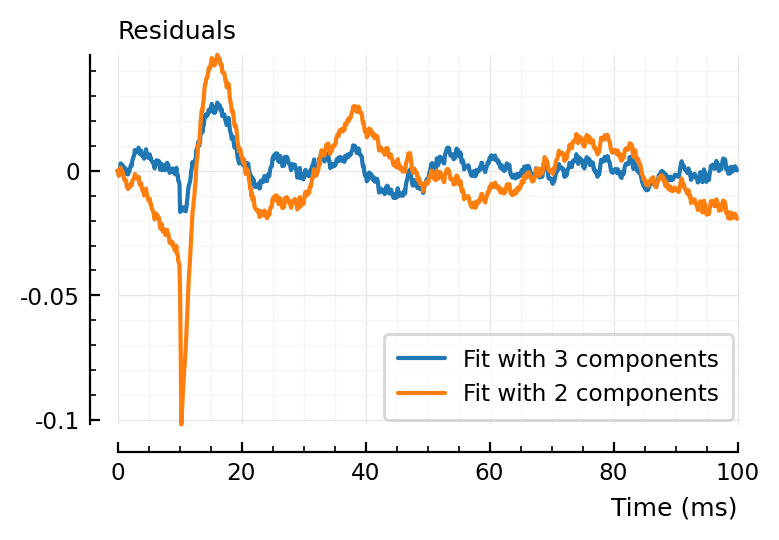

In [42]:
plotsig(fit.resid, p, label = "Fit with 3 components")
plotsig(fit2.resid, p, label = "Fit with 2 components", hylabel = "Residuals")
plt.legend();

Ah ok it's not so bad actually. It's just there at the tx_delay discontinuity that's it quite a bit larger.

In [43]:
with_title(title::String, printf; kw...) = x -> begin
    println(title, "\n")
    printf(x; kw...)
end;

In [44]:
df = DataFrame(fit_with_3_components = abs.(fit.resid), fit_with_2_components = abs.(fit2.resid))
describe(df, :mean, :median, :max) |> with_title("Absolute residuals:", printsimple)

Absolute residuals:

 variable               mean     median   max    
─────────────────────────────────────────────────
 fit_with_3_components  0.00457  0.00311  0.0273
 fit_with_2_components  0.0121   0.00915  0.102

Ok so it is worse yes, median and mean 2x to 3x higher, max 4x higher.

We'll go with the three components for now.

9 parameters  
(1 + 2 + 3 + 3: tx_delay, linear_PSP, and two weighted gaussians) 

In [45]:
# rename, to free `fit` name
fit_avg = fit;

## Fit STA model to individual STAs

Numbers from tables in https://tfiers.github.io/phd/nb/2022-09-09__Conntest_with_template_matching.html#use-as-conntest-for-all-exc-inputs

In [77]:
STA = calc_STA(565 => 1, s, p)
data = normalize(STA)
@time fit = curve_fit(model, [], data, p0_vec);

  0.378892 seconds (186.11 k allocations: 463.471 MiB, 12.56% gc time)


In [87]:
function plotfit(STA, fit; kw...)
    plt.subplots()
    modelfit = model_STA(p; toCV(fit.param)..., plot_components = true)
    plt.subplots()
    plotsig(STA |> normalize, p)
    plotsig(modelfit, p; kw...)
end;

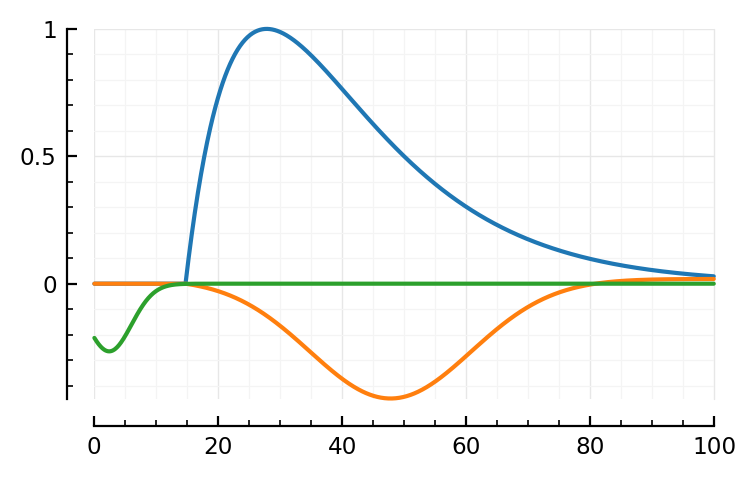

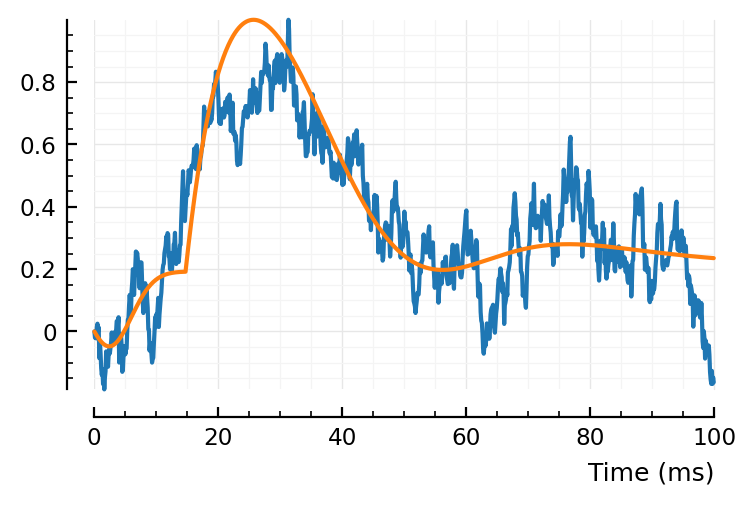

In [81]:
plotfit(STA, fit);

Hahaha. Too many DOF.

Let's add some bounds.

### Parameter bounds

In [130]:
pbounds = (
    tx_delay = [eps(), 60ms],    # Haven't read about any spike transmission delays > 20 ms yet.
    PSP_bump = (
        τ1 = [0, 200] * ms,      # = τ_syn
        τ2 = [0, 200] * ms,      # = τ_mem = RC
    ),
    PSP_dip  = (
        loc    = [0, 40] * ms,   # This is in time after tx_delay
        scale  = [5, 20] * ms,
        weight = [0, 2],         # Always downwards
    ),
    STA_dip  = (
        loc    = [20, 80] * ms,  # Time from start
        scale  = [10, 100] * ms,
        weight = [0, 2],         # Always downwards
    ),
);

In [131]:
pb_flat = collect(CVec(pbounds))
lower = pb_flat[1:2:end]
upper = pb_flat[2:2:end];

In [82]:
@time fit = curve_fit(model, [], data, p0_vec; lower, upper);

  1.136907 seconds (623.04 k allocations: 1.523 GiB, 8.53% gc time)


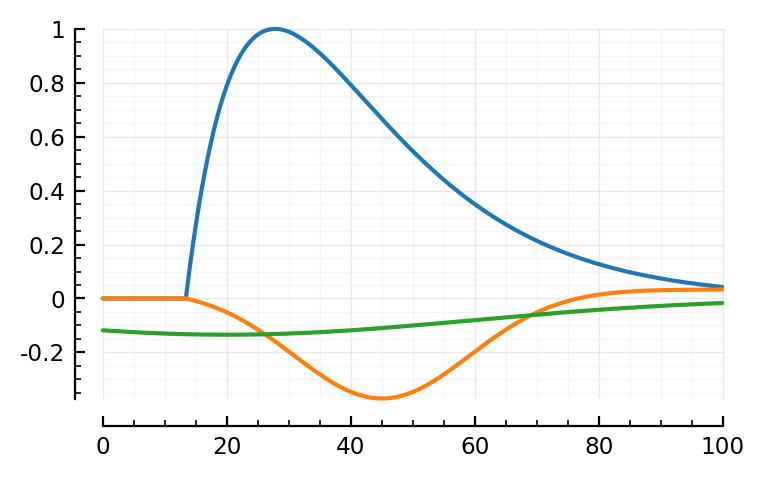

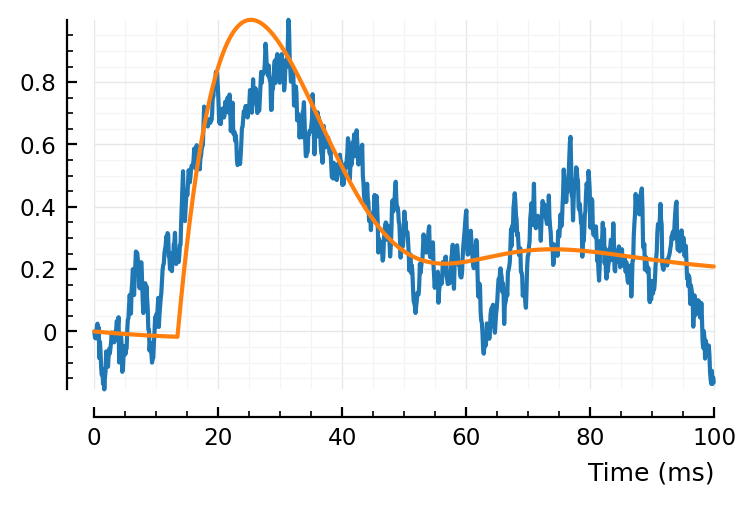

In [83]:
plotfit(STA, fit)

Ok sure. It made a positive bump now, but, fine.

Now repeat for some more inputs

### Exc inputs

In [100]:
input_type = Dict()
foreach(m -> (input_type[m] = :exc), s.exc_inputs[1])
foreach(m -> (input_type[m] = :inh), s.inh_inputs[1])
foreach(m -> (input_type[m] = :non), s.non_inputs[1]);

In [132]:
function fit_and_plot(inputs...)
    for m in inputs
        STA = calc_STA(m => 1, s, p)
        type = input_type[m]
        if (type == :inh)
            STA .*= -1
        end
        data = normalize(STA)
        fit = curve_fit(model, [], data, p0_vec; lower, upper);
        plotfit(STA, fit, hylabel = "$m ($type input)")
    end
end;

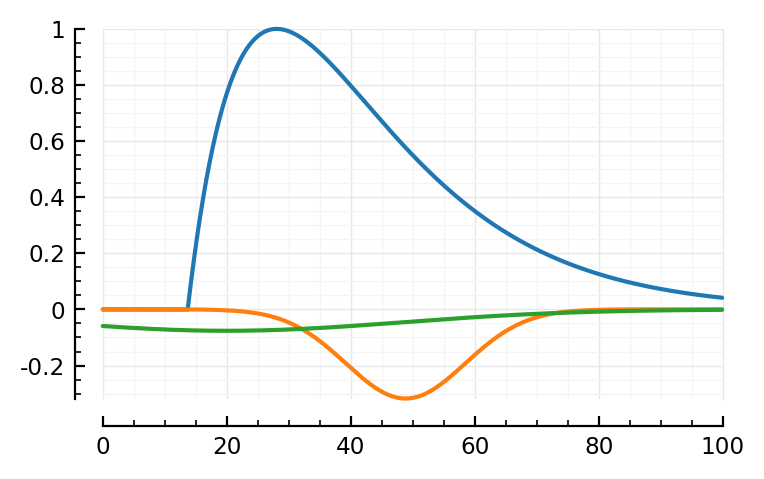

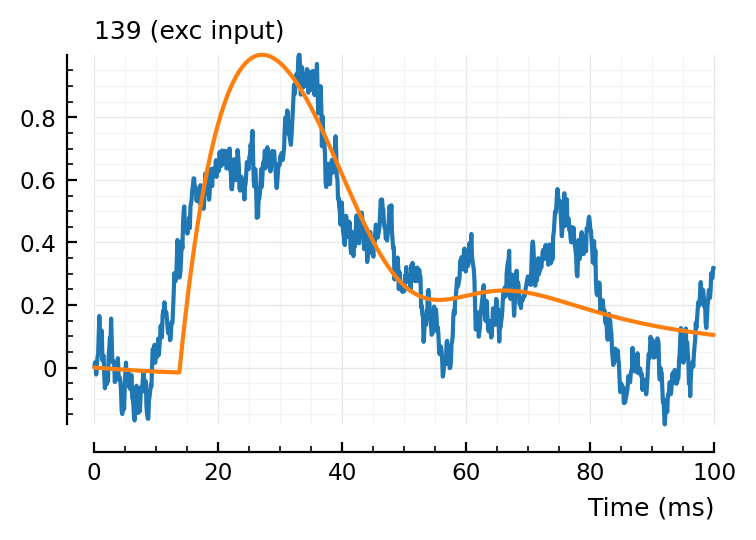

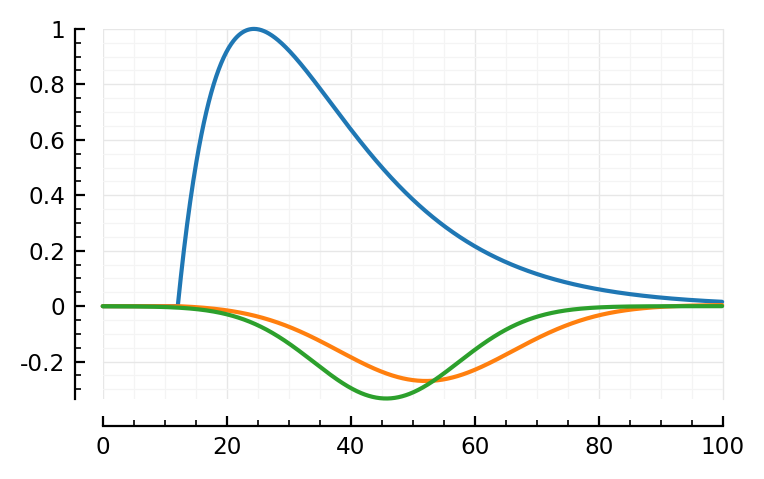

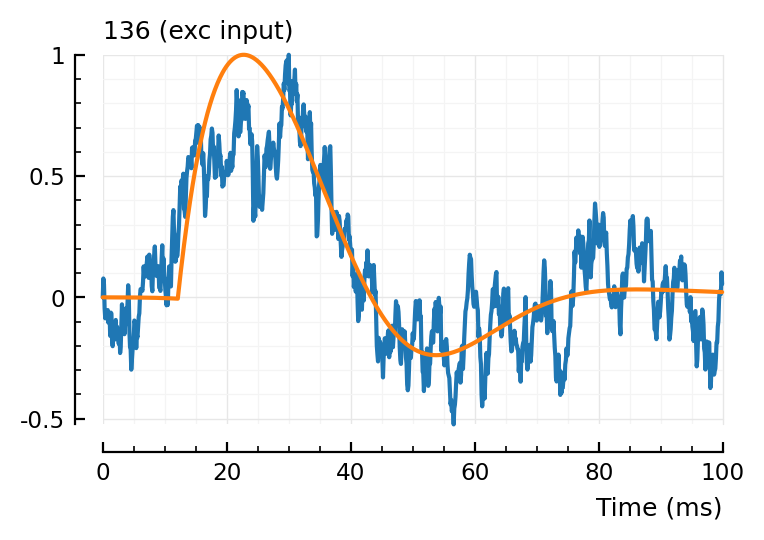

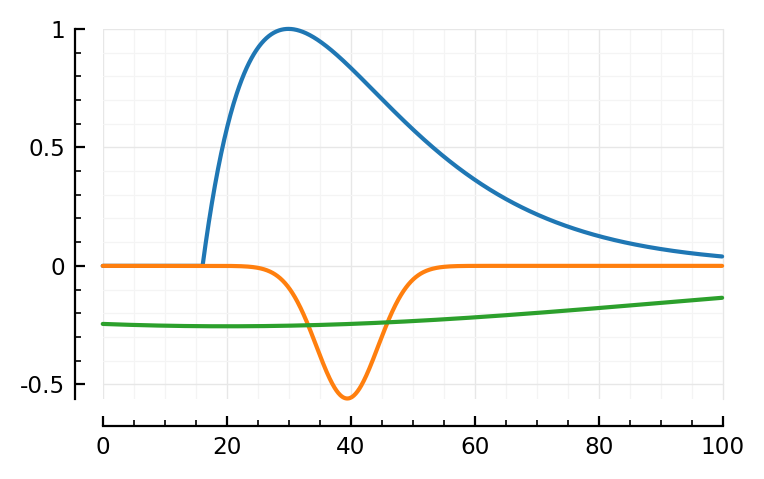

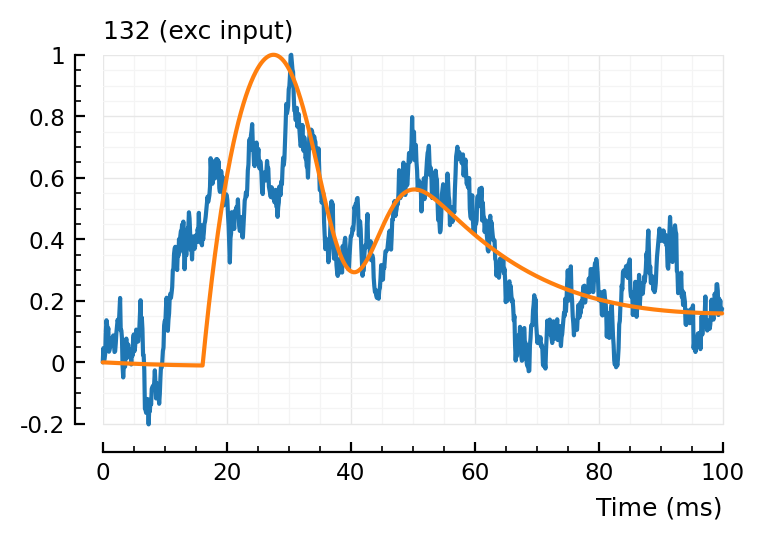

In [102]:
fit_and_plot(139, 136, 132);

132, not too good.  
Is difficult to detect too (pval ptp = 0.03.  pval corr-with-avgSTA = 0.12)

Still too many degrees of freedom maybe

### Inh inputs

For these, we'd have to add an extra global scale parameter, so that the whole thing can be flipped upside down.
I'll cheat for now and supply –STA as data to fit.

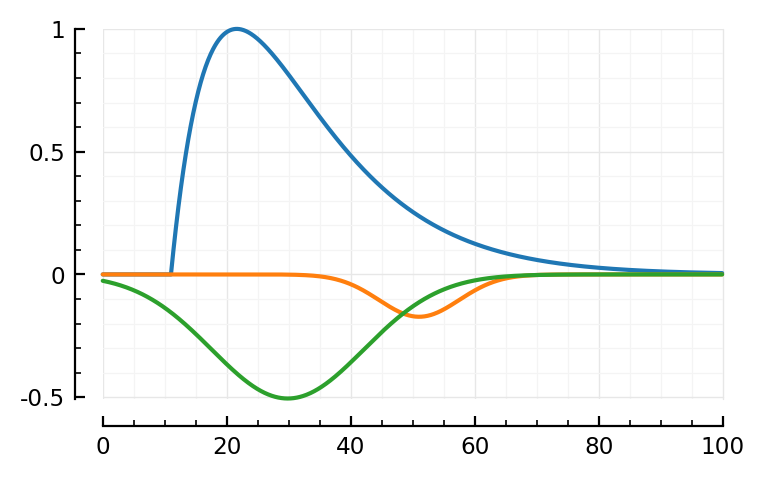

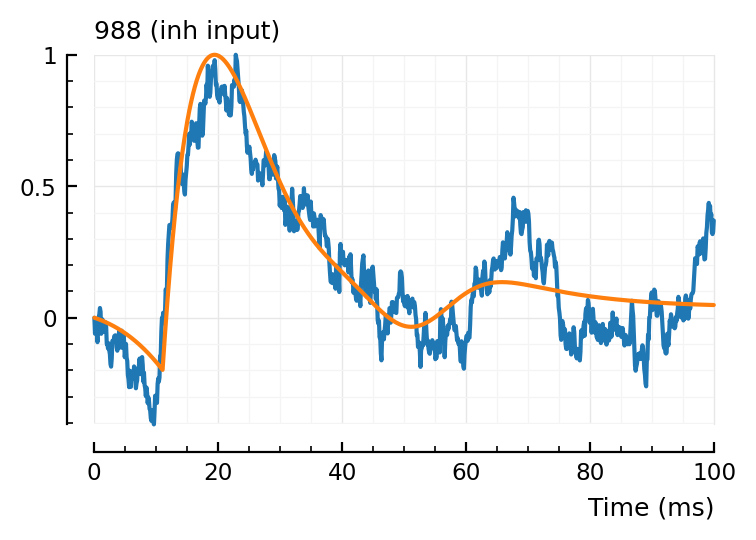

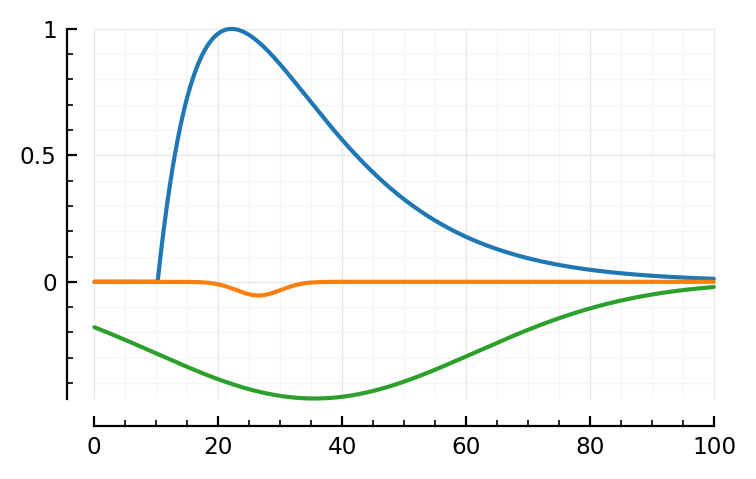

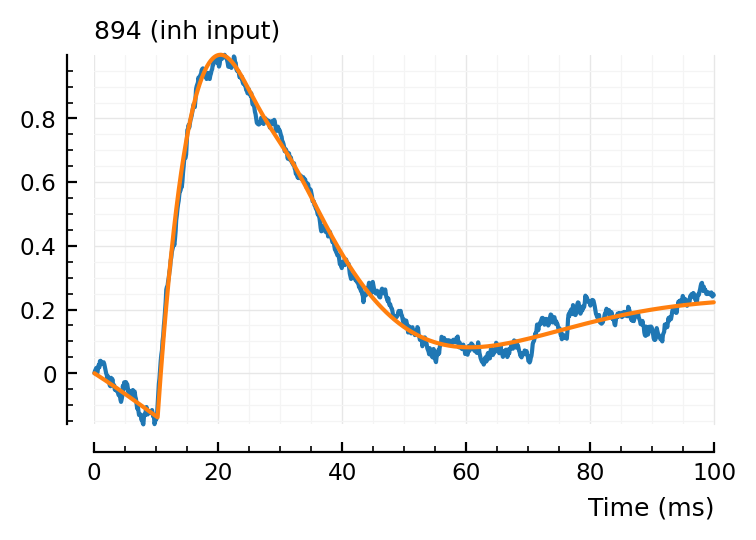

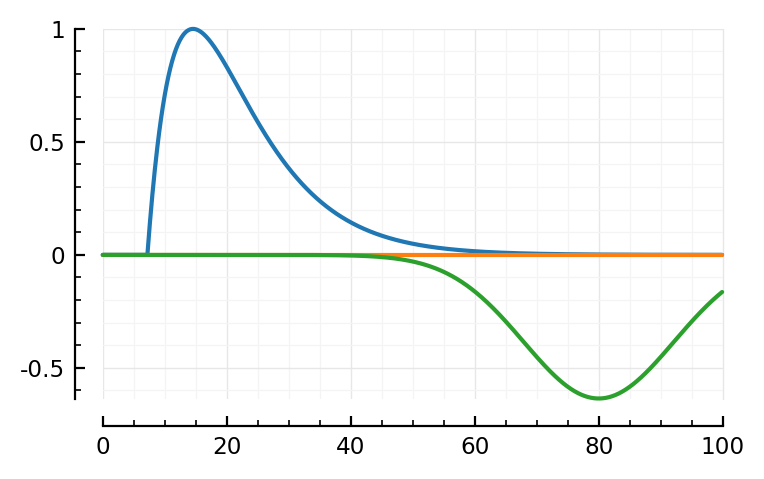

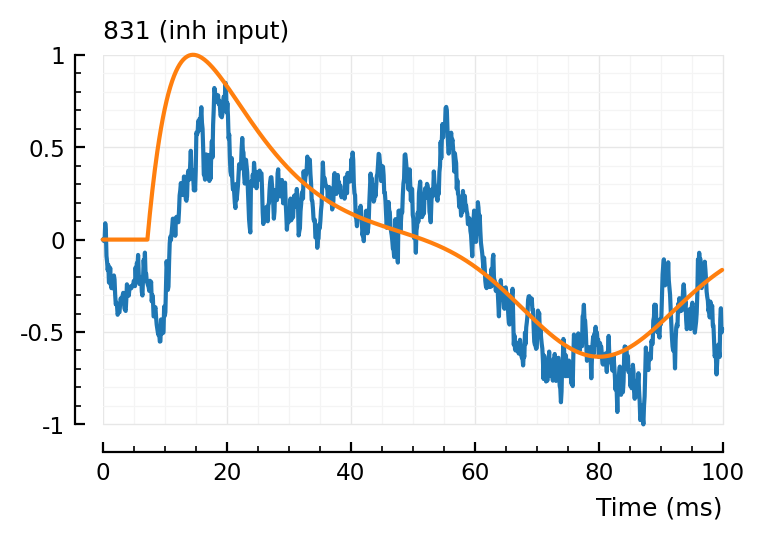

In [103]:
fit_and_plot(988, 894, 831)

Wauw, that second fit.  
Maybe we don't need the orange ('PSP') dimple after all.

Hah the last one, green went exactly up to our bound (loc upper: 80 ms)

### Non-inputs

(Formerly known as 'unconnected')

These might be problematic for this idea :)  
(I suspect the optimizer will always find a kinda decent fit here, too).

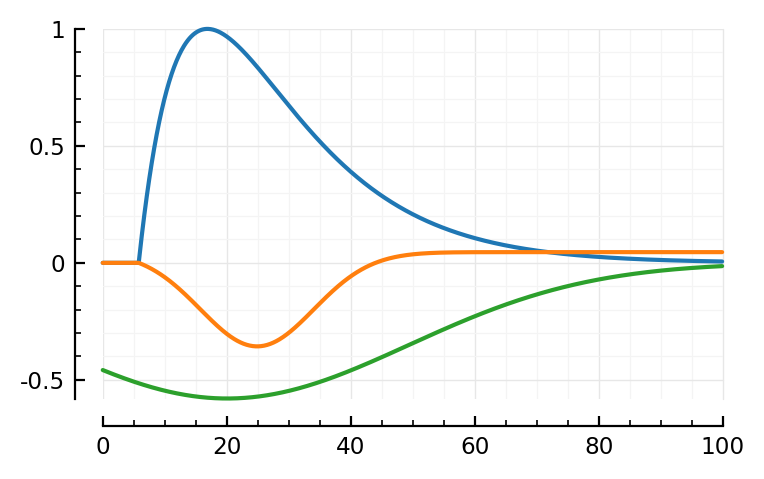

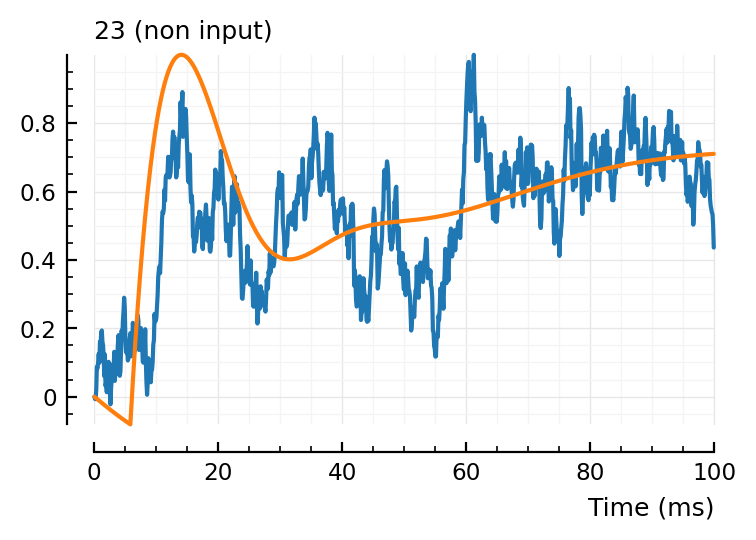

In [107]:
fit_and_plot(23)

Hm not bad! There is lotsa noisy squiggles we don't fit (which is good).

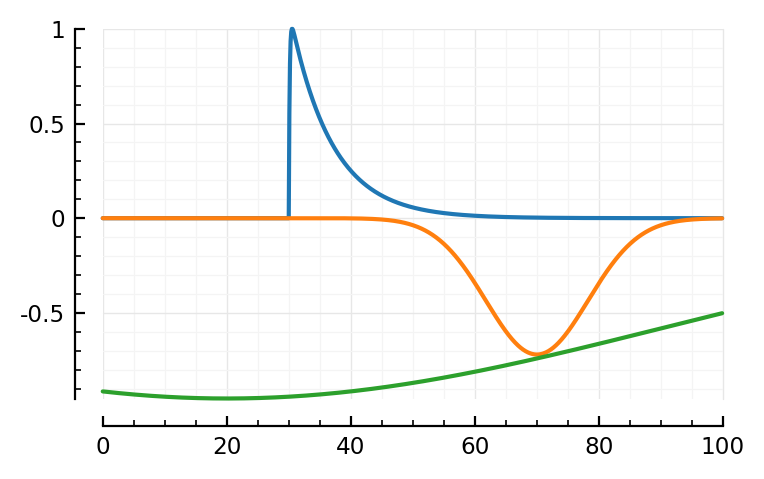

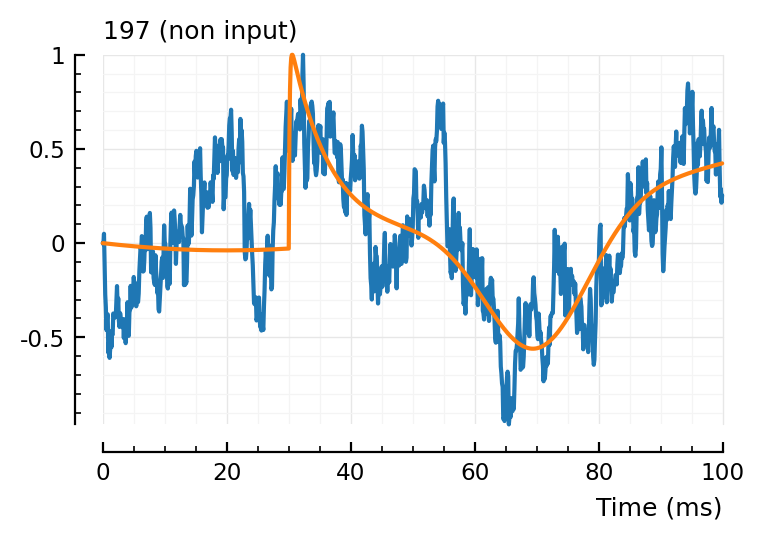

In [108]:
fit_and_plot(197)

Hahaha.  
yeah.

Also I note the algo is cheating with the green curve: because the final function gets `ref_to_start`'ted, the algo can use the dimples (especially the green one) to have above-the-start effects too.

I think we can drop the ref-to-start in the model function: the blue and orange components are already zero at start. And the green can then not cheat anymore.

In [134]:
# fit_and_plot(367)
# 
# This ones gives an `InexactError: trunc(Int64, NaN)`,
# from `delay_size = round(Int, tx_delay / Δt)`

# I.e. the result of that division would be a NaN?
# but can't be, `round(Int, 0/0.0001)` works and is 0.
# 
# Anyway, let's try setting the lower bound of tx_delay to eps()
# 
# nope, that didn't change it.
# Maybe an error in the LsqFit package.

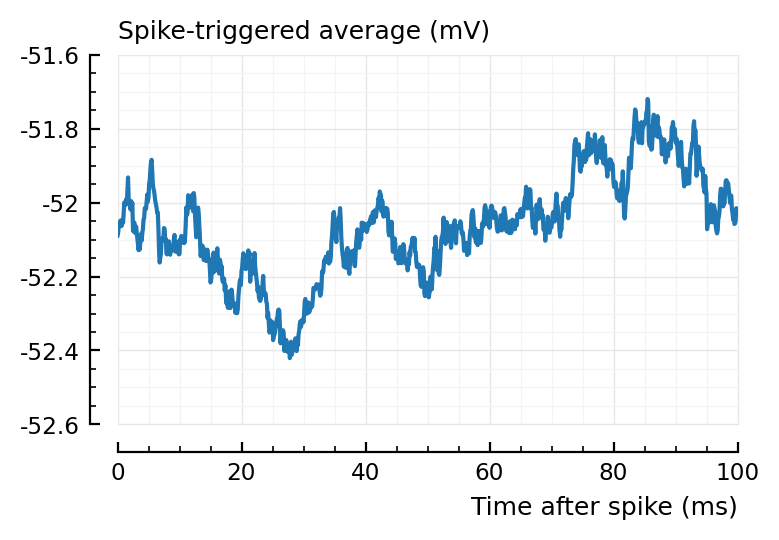

In [136]:
plotSTA(367=>1,s,p);

In [140]:
# Not too special.
# Hm, maybe the negative tendency throws it off: I also got this error when trying to fit the inhibitory STAs without inverting them.
# 
# ...soo, if I invert this STA, does it not error?

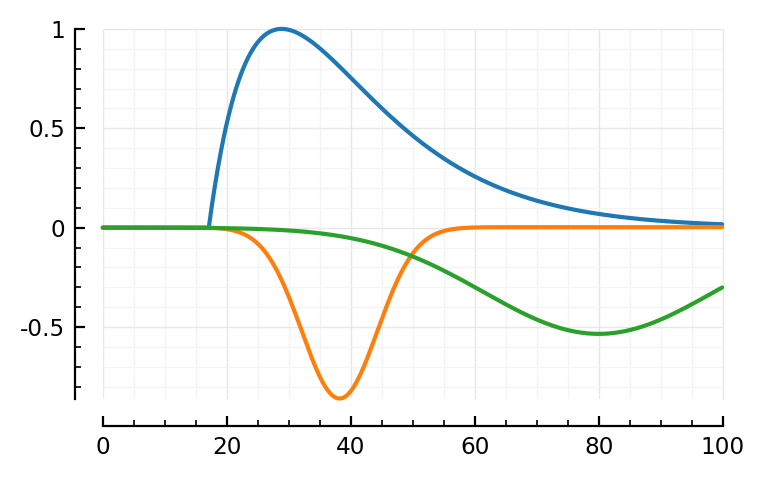

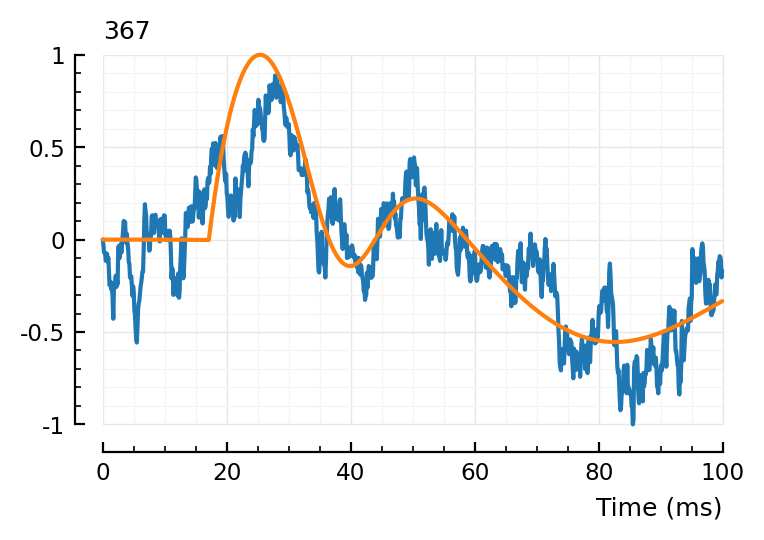

In [141]:
m = 367
STA = - calc_STA(m => 1, s, p)
data = normalize(STA)
fit = curve_fit(model, [], data, p0_vec; lower, upper)
plotfit(STA, fit, hylabel = "$m");

In [144]:
# Yep!
# So that's the problem.
# And like said before, this might be fixed by adding a global scale parameter, neg and pos.

Moving on to another unconnected

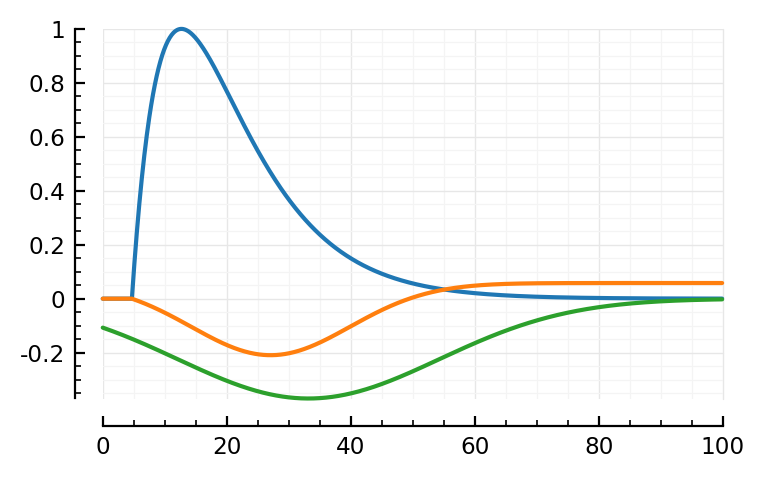

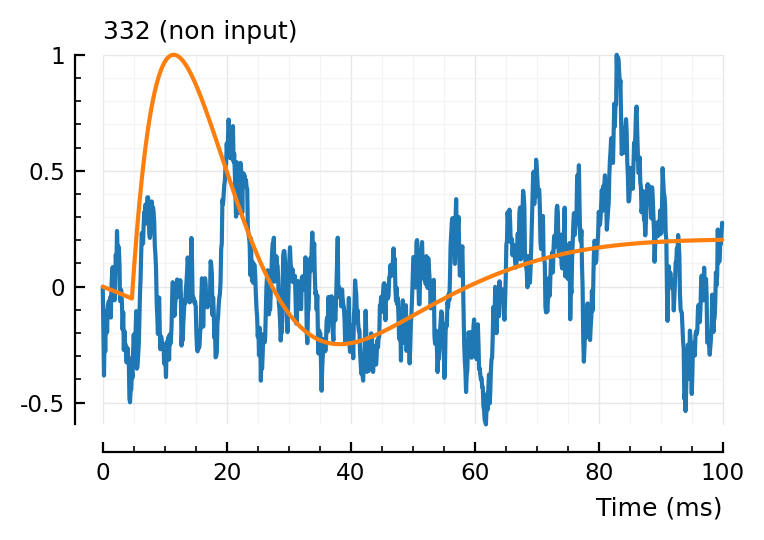

In [138]:
fit_and_plot(332)

Great, very noisy non-fit, perfect. (non-ironic)

---

Alright, time to move on to a new notebook.

We'll recreate the model, with:
- no `ref_to_start`
- only one dip (the global one)
- a global scale (flipping up/down) parameter

We hope this will fix the problems seen here:
- error / cheating for downwards STAs
- less creative freedom for making those wonky fits

Overall, this idea has been a success: a relatively simple model (after culling one gaussian: only six params), and fitting works real well, and is not excruciatingly slow (with a probable Jacobian autodiff speedup still lying for the taking).

---
Another idea: maybe weight the earlier samples (around the bump) more in the fit (you can specify an extra weight vector to the least-squares nonlinear curve fitting function, to weight the MSE calculation I presume).